In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm.auto import tqdm
import scipy as sp

sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})
sns.set_context("notebook", font_scale=1)

# Import Data

In [30]:
prices_df = pd.read_csv('../data/clean/prices.csv')

In [50]:
fed_trades_df = pd.read_csv('../data/clean/fed_trades.csv')

# Clean Data

In [52]:
# Fix dates
prices_df['datetime'] = pd.to_datetime(prices_df['datetime'])
fed_trades_df['date'] = (pd.to_datetime(fed_trades_df['trade_date']).dt.date).astype(str)

In [53]:
def get_ticker_type(ticker_desc):
    
    ticker_maturity_type = ''
    ticker_yield_type = ''
    
    # Maturity type
    if 'short' in ticker_desc.lower() or '0-5' in ticker_desc:
        ticker_maturity_type = 'Short-Term'
    elif 'intermediate' in ticker_desc.lower():
        ticker_maturity_type = 'Intermediate'
    elif 'angel' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'iboxx high yield' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'xtrackers' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'bloomberg barclays high yield' in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'ishares iboxx us dollar' in ticker_desc.lower():
        ticker_maturity_type = 'Intermediate'
    elif 'iShares Broad US Dollar High Yield Corporate'.lower() in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
    elif 'iShares Broad US Dollar Investment Grade'.lower() in ticker_desc.lower():
        ticker_maturity_type = 'Mixed'
        
    # Yield type
    if 'high' in ticker_desc.lower():
        ticker_yield_type = 'High Yield'
    else: #'investment grade' in ticker_desc.lower():
        ticker_yield_type = 'Investment Grade'
        
    return (ticker_maturity_type, ticker_yield_type)
        
fed_trades_df['ticker_maturity_type'] = fed_trades_df['ticker_desc'].apply(lambda x: get_ticker_type(x)[0])
fed_trades_df['ticker_yield_type'] = fed_trades_df['ticker_desc'].apply(lambda x: get_ticker_type(x)[1])
fed_trades_df['ticker_type'] = fed_trades_df['ticker_maturity_type'] + ' ' + fed_trades_df['ticker_yield_type']

In [159]:
# Add ticker info
data_df = prices_df.merge(
    fed_trades_df[
        ["ticker", "ticker_desc", "ticker_type", "ticker_yield_type", "ticker_maturity_type"]
    ].drop_duplicates(),
    on=["ticker"],
    how="left",
)

In [161]:
# Clean out times outside certain interval
data_df['hhmm_i'] = data_df['datetime'].dt.hour*100 + data_df['datetime'].dt.minute
data_df = data_df.query('hhmm_i >= 930 & hhmm_i <= 1600').copy()

In [162]:
# Sort
data_df = data_df.sort_values(by = ['ticker', 'date', 'datetime']).copy()

In [163]:
# Add price index
data_df['price_idx_100'] = 100*data_df['price']/data_df.groupby('ticker')['price'].transform('first')

In [164]:
# Fix date col
data_df['date'] = pd.to_datetime(data_df['date'])

In [165]:
data_df.head()

,ticker,date,datetime,price,log_price,return,return_squared,ticker_desc,ticker_type,ticker_yield_type,ticker_maturity_type,hhmm_i,price_idx_100
23,ANGL,2020-04-01,2020-04-01 09:30:00,25.20,3.226844,0.000000,0.000000e+00,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,930,100.000000
24,ANGL,2020-04-01,2020-04-01 09:30:05,25.05,3.220874,-0.005970,3.564289e-05,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,930,99.404762
25,ANGL,2020-04-01,2020-04-01 09:30:10,25.05,3.220874,0.000000,0.000000e+00,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,930,99.404762
26,ANGL,2020-04-01,2020-04-01 09:30:15,25.04,3.220475,-0.000399,1.594256e-07,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,930,99.365079
27,ANGL,2020-04-01,2020-04-01 09:30:20,25.44,3.236323,0.015848,2.511652e-04,VanEck Vectors Fallen Angel High Yield Bond ETF,Mixed High Yield,High Yield,Mixed,930,100.952381


In [166]:
data_daily_df = data_df.groupby(
    [
        "ticker",
        "ticker_desc",
        "ticker_type",
        "ticker_yield_type",
        "ticker_maturity_type",
        pd.Grouper(key="date", freq = '1d'),
    ]
)['price'].last().reset_index()

In [167]:
# Add price index
data_daily_df["price_idx_100"] = (
    100 * data_daily_df["price"] / data_daily_df.groupby("ticker")["price"].transform("first")
)

# Plot Data

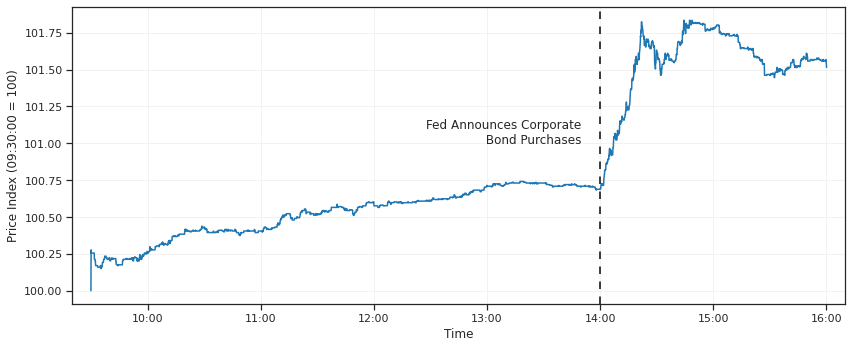

In [220]:
# Prep data
temp_df = data_df.query('ticker == "VCIT" & date == "2020-06-15"').sort_values(by = 'datetime')
temp_df['price_idx_100'] = 100*temp_df['price']/temp_df['price'].iloc[0]
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])

# Figure
fig, ax = plt.subplots(figsize = (12,5))
sns.lineplot(x = 'datetime', y = 'price_idx_100', data = temp_df, ax = ax)
plt.text(pd.to_datetime('2020-06-15 13:50:00'), 101, 'Fed Announces Corporate\n Bond Purchases', ha = 'right')
plt.axvline(pd.to_datetime('2020-06-15 14:00:00'), 0, 1, lw = 1.5, ls = (0,(5,5)), color = 'k')


# Fix axis labels
plt.xlabel('Time')
plt.ylabel('Price Index (09:30:00 = 100)')
plt.xlim(pd.to_datetime('2020-06-15 09:20:00'), pd.to_datetime('2020-06-15 16:10:00'))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))

# Save
plt.tight_layout()
plt.savefig("../exhibits/price_June15_VCIT.pdf")

## All Bonds

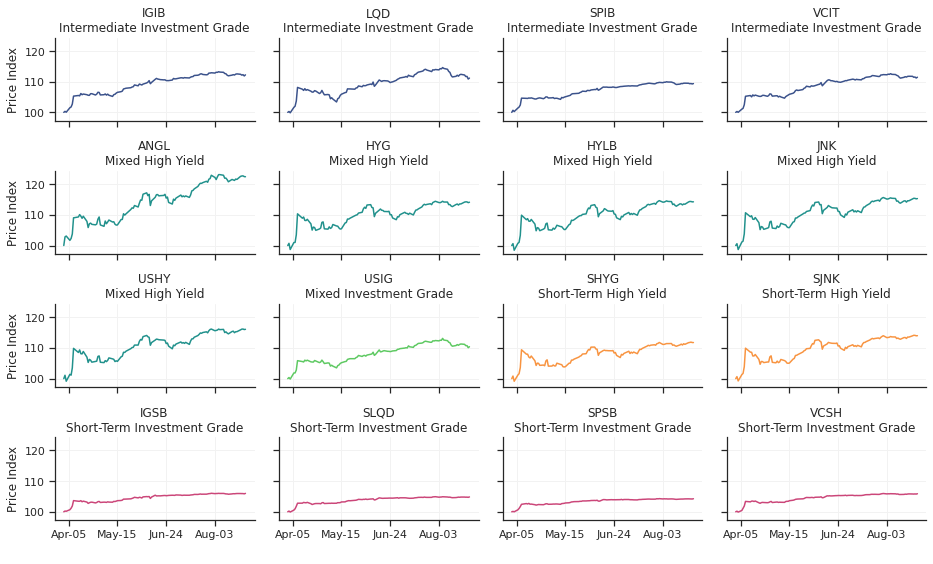

In [170]:
# Colors to use to mark the bonds
ticker_type_colors = dict(
    zip(
        data_df.groupby("ticker_type").first().index,
        (sns.color_palette("viridis", 3) + sns.color_palette("plasma_r", 3)),
    )
)

g = sns.FacetGrid(
    data_daily_df.sort_values(by=["ticker_type", "ticker", "date"]),
    col="ticker",
    col_wrap=4,
    sharex=True,
    sharey=True,
    aspect=1.65,
    height=2,
)
g = (
    g.map(plt.plot, "date", "price_idx_100")
    .set_titles("{col_name}")
    .set_axis_labels(" ", "Price Index")
)


# # Plot settings
ax = g.axes.flatten()
for i in range(16):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    ticker_type = data_df.query("ticker == @ticker")["ticker_type"].iloc[0]
    ax[i].set_title(f"{ticker}\n{ticker_type}")
    ax[i].get_lines()[0].set_color(ticker_type_colors.get(ticker_type))

plt.tight_layout()
plt.savefig("../exhibits/prices_16tickers.pdf")

## Comovement between Bond Classes

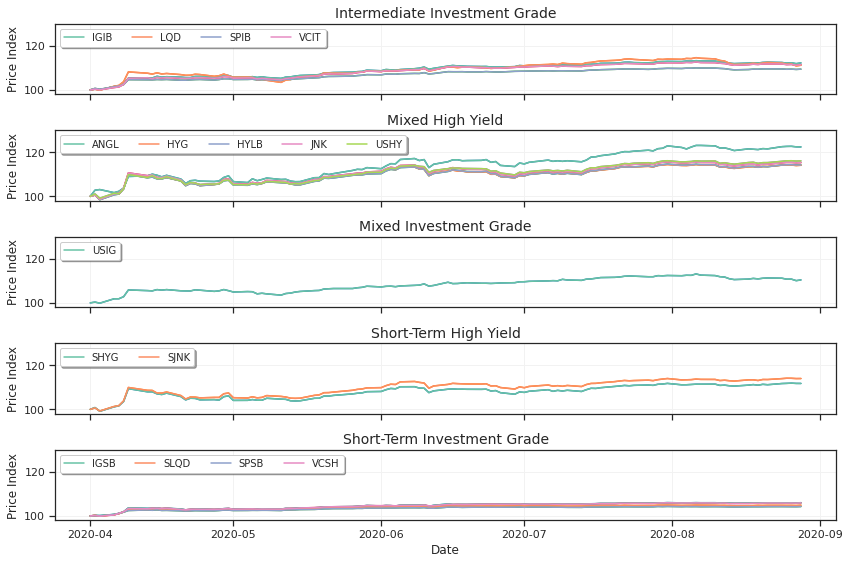

In [171]:
data_daily_df_groups = list(data_daily_df.groupby('ticker_type'))

fig, ax = plt.subplots(figsize = (12,8), nrows=5, ncols=1, sharex = True)

for i in range(len(data_daily_df_groups)):
    bond_type, bond_data = data_daily_df_groups[i]
    ax = plt.subplot(5, 1, i+1)
    
    sns.lineplot(x = 'date', y = 'price_idx_100', hue = 'ticker', data = bond_data, ax = ax)
    
    # Plot
    sns.lineplot(
        x="date",
        y="price_idx_100",
        hue="ticker",
        palette=sns.color_palette("Set2", len(bond_data['ticker'].unique())),
        data=bond_data,
        ax=ax,
        **{"lw": 1.5},
    )

    # Plot settings
    plt.title(f"{bond_type}", fontsize=14)
    plt.ylabel("Price Index")
#     ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
#     ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())

    if i < 4:
        ax.set_xticklabels([])
        plt.xlabel("")
    else:
        plt.xlabel("Date")

    plt.ylim(98, 130)
    
    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    n_tickers = len(bond_data['ticker'].unique())
    ax.legend(
        loc="upper left",
        handles=handles[-n_tickers:],
        labels=labels[-n_tickers:],
        title="",
        fontsize=10,
        ncol=5,
        shadow=True,
    )
    
plt.tight_layout()
plt.savefig("../exhibits/prices_daily_type.pdf")

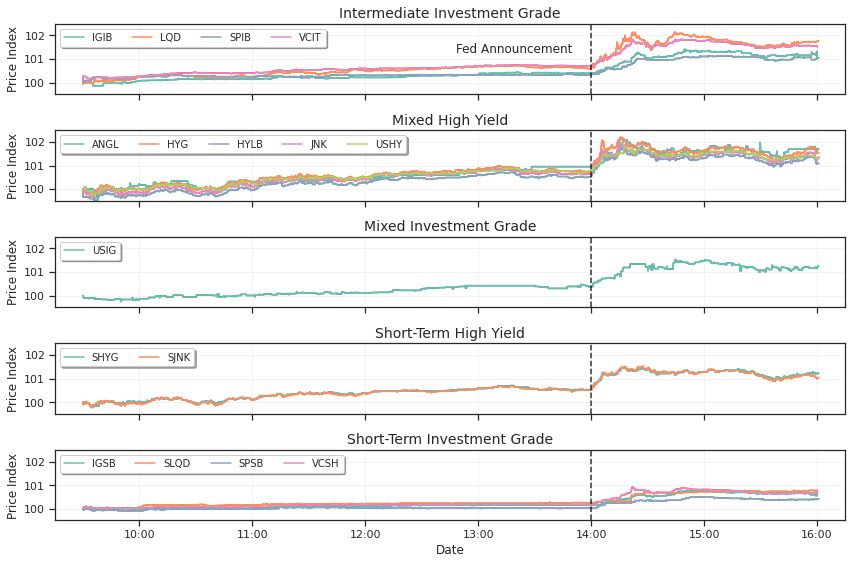

In [213]:
data_df_groups = list(data_df.groupby('ticker_type'))

fig, ax = plt.subplots(figsize = (12,8), nrows=5, ncols=1, sharex = True)

for i in range(len(data_df_groups)):
    bond_type, bond_data = data_df_groups[i]
    ax = plt.subplot(5, 1, i+1)
    
    bond_data = bond_data.query('date == "2020-06-15"').copy()
    bond_data['price_idx_100']= 100*bond_data['price']/bond_data.groupby(['ticker'])['price'].transform('first')
    sns.lineplot(x = 'datetime', y = 'price_idx_100', hue = 'ticker', data = bond_data, ax = ax)
    
    # Plot
    sns.lineplot(
        x="datetime",
        y="price_idx_100",
        hue="ticker",
        palette=sns.color_palette("Set2", len(bond_data['ticker'].unique())),
        data=bond_data,
        ax=ax,
        **{"lw": 1.5},
    )
    
    
    # Vline at 2PM
    ax.axvline(
        x=pd.to_datetime("2020-06-15 14:00:00"), ymin=0, ymax=1, lw=1.5, ls="--", color="k", alpha = 0.8
    )

    # Plot settings
    plt.title(f"{bond_type}", fontsize=14)
    plt.ylabel("Price Index")
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
#     ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())

    if i < 4:
        ax.set_xticklabels([])
        plt.xlabel("")
    else:
        plt.xlabel("Date")

    plt.ylim(99.5, 102.5)
    
    # Only for the first plot
    if i == 0:
        # Text
        plt.text(
            pd.to_datetime("2020-06-15 13:50:00"),
            101.5,
            "Fed Announcement",
            size=12,
            ha="right",
            va="center_baseline",
        )
        
    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    n_tickers = len(bond_data['ticker'].unique())
    ax.legend(
        loc="upper left",
        handles=handles[-n_tickers:],
        labels=labels[-n_tickers:],
        title="",
        fontsize=10,
        ncol=5,
        shadow=True,
    )
    
    plt.xlim(pd.to_datetime('2020-06-15 09:15:00'), pd.to_datetime('2020-06-15 16:15:00'))
    
plt.tight_layout()
plt.savefig("../exhibits/prices_june15_type.pdf")